# 데이터 중복 제거

In [134]:
import json
INPUT_PATH = "/opt/ml/input/data/v3.5/summary_v3.5_1500.json"
OUTPUT_PATH = "/opt/ml/input/data/v3.5/summary_v3.5_1500_train.json"
with open(INPUT_PATH, "r") as f:
    data = json.load(f)
len(data)

9572

## 테스트 데이터셋 및 특정 상품 제거

In [136]:
# 테스트 데이터셋 말고도 제거하고 싶은 상품명
extra_prod_name = []

In [137]:
# 테스트 데이터셋의 상품명

import pandas as pd
test_df = pd.read_csv("/opt/ml/input/data/test_data.csv")

test_prod_name = set(test_df["prod_name"].tolist())
print("테스트 상품명 개수:", len(test_prod_name))

test_prod_name.update(extra_prod_name)
print("추가로 삭제할 상품명 포함해서 삭제할 개수 (테스트 상품명과 중복 제거):", len(test_prod_name))

테스트 상품명 개수: 50
추가로 삭제할 상품명 포함해서 삭제할 개수 (테스트 상품명과 중복 제거): 50


In [138]:
# 테스트 데이터와 리뷰가 같은 학습 데이터 제거

deleted_prod_name = set()

test_reviews = dict() # 테스트 데이터의 리뷰
for idx, item in enumerate(data):
    if item["prod_name"] in test_prod_name: # 학습 데이터 상품명이 테스트 데이터셋에 있으면
        test_reviews[item["review"]] = []

train_data = []

for idx, item in enumerate(data):
    if item["review"] in test_reviews: # 학습 데이터 리뷰가 테스트 데이터 리뷰와 같으면
        test_reviews[item["review"]].append(idx)
        deleted_prod_name.add(item["prod_name"])
    else:
        train_data.append(item)

print(f"{len(data)} -> {len(train_data)} : {len(data) - len(train_data)} 삭제")
print("삭제된 상품명 개수:", len(deleted_prod_name))
# print("삭제된 상품명:")
# print(sorted(list(deleted_prod_name)))

9572 -> 9354 : 218 삭제
삭제된 상품명 개수: 82


## 중복 학습 데이터 삭제 (리뷰 같은 것)

In [150]:
from collections import defaultdict

train_reviews = defaultdict(list)

filtered_train_data = []

for idx, item in enumerate(train_data):
    train_reviews[item["review"]].append(idx)
    if len(train_reviews[item["review"]]) > 1: # 리뷰 중복
        continue
    
    filtered_train_data.append(item)

print(f"{len(train_data)} -> {len(filtered_train_data)} : {len(train_data) - len(filtered_train_data)} 중복")       

9354 -> 6033 : 3321 중복


## 요약문 없는 데이터 제거

In [151]:
before_len = len(filtered_train_data)
filtered_train_data = [item for item in filtered_train_data if isinstance(item["summary"], str) and len(item["summary"]) > 0]
after_len = len(filtered_train_data)
print("요약문 없어서 삭제된 데이터 개수:", before_len - after_len)
print("남은 데이터 개수:", after_len)

요약문 없어서 삭제된 데이터 개수: 968
남은 데이터 개수: 5065


In [142]:
print("Saved at:", OUTPUT_PATH)
with open(OUTPUT_PATH, "w") as f:
    json.dump(filtered_train_data, f, ensure_ascii=False)

Saved at: /opt/ml/input/data/v3.5/summary_v3.5_1500_train.json


# 데이터셋 확인

## 중복 리뷰 필터링 잘 됐는지 확인

In [152]:
with open(OUTPUT_PATH, "r") as f:
    data = json.load(f)
    
print("데이터 개수:", len(data))
print("요약문 없는 개수:", len([0 for item in data if len(item["summary"]) == 0]))

unique_reviews = set()

for idx, item in enumerate(data):
    unique_reviews.add(item["review"])

print("중복 요약문 개수:", len(data) - len(unique_reviews))

데이터 개수: 5065
요약문 없는 개수: 0
중복 요약문 개수: 0


## 데이터셋 길이 확인

In [144]:
data[0].keys()

dict_keys(['id', 'prod_name', 'review', 'summary', 'review_no_space_length', 'review_tokens'])

In [145]:
len_list = []
for item in data:
    len_list.append(item["review_no_space_length"])
len_list.sort()
print(len_list[0], len_list[-1], sum(len_list) / len(len_list))

336 1256 917.4076999012833


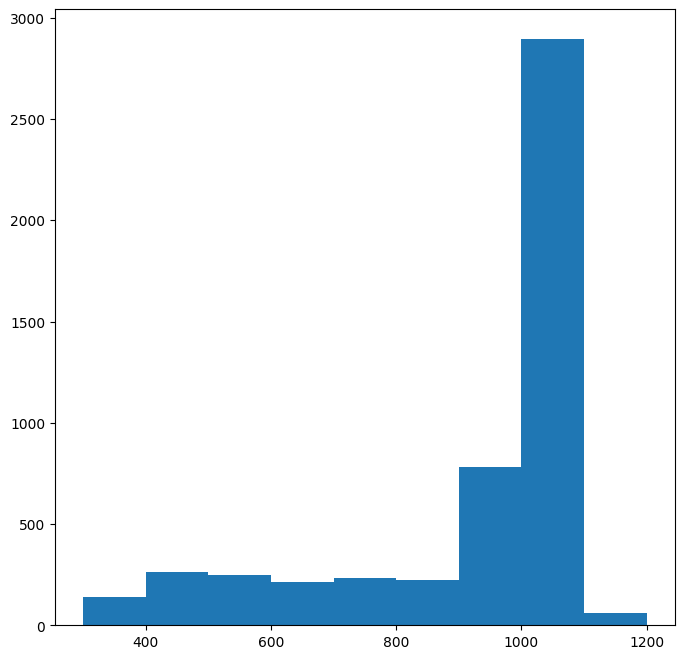

In [146]:
import matplotlib.pyplot as plt

left = min(len_list)
left = left // 100 * 100
right = max(len_list)
right = (right // 100 + 1) * 100

bins = range(left, right, 100)

plt.figure(figsize=(8,8))

plt.hist(len_list, bins)
plt.show()